In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from datetime import timedelta
from prophet import Prophet

## Predição - Cargas Linha de Montagem

In [45]:
df = pd.read_csv("../data/cargas-dia-solar-linha.csv", parse_dates=["delivery_date"],index_col=[0])
#df['loaded_vehicles'] = df['loaded_vehicles'].astype(int)
df = df.sort_values("delivery_date")
df.head()

,loaded_vehicles
delivery_date,
2021-02-02,1
2021-02-04,2
2021-02-05,3
2021-02-06,1
2021-02-09,4


In [48]:
# Adicionando datas faltantes
# primeira_data = df['delivery_date'][0]
# ultima_data = df['delivery_date'].iloc[-1]
df_range = pd.DataFrame({'delivery_date':pd.date_range(start='2021-02-02', end='2025-05-19')})
df_range = df_range.set_index('delivery_date')
df_range.tail()


""
delivery_date
2025-05-15
2025-05-16
2025-05-17
2025-05-18
2025-05-19


In [49]:
df2 = pd.concat([df_range, df], axis=1).reindex(df_range.index)
df2['loaded_vehicles'] = df2.fillna(0)

df2.head()

,loaded_vehicles
delivery_date,
2021-02-02,1.0
2021-02-03,0.0
2021-02-04,2.0
2021-02-05,3.0
2021-02-06,1.0


In [52]:
# soma cumulativa
df2['cumulative_loaded'] = df2['loaded_vehicles'].cumsum()
print(df2.head())

               loaded_vehicles  cumulative_loaded
delivery_date                                    
2021-02-02                 1.0                1.0
2021-02-03                 0.0                1.0
2021-02-04                 2.0                3.0
2021-02-05                 3.0                6.0
2021-02-06                 1.0                7.0


In [59]:
df_teste = df2.copy()
df_teste=df_teste.reset_index()
df_teste = df_teste[df_teste['delivery_date'].between('2021-02-02','2024-05-14')]

In [60]:
df_teste.tail()

,delivery_date,loaded_vehicles,cumulative_loaded
1193,2024-05-10,1923.0,870984.0
1194,2024-05-11,1126.0,872110.0
1195,2024-05-12,0.0,872110.0
1196,2024-05-13,889.0,872999.0
1197,2024-05-14,2032.0,875031.0


<Axes: >

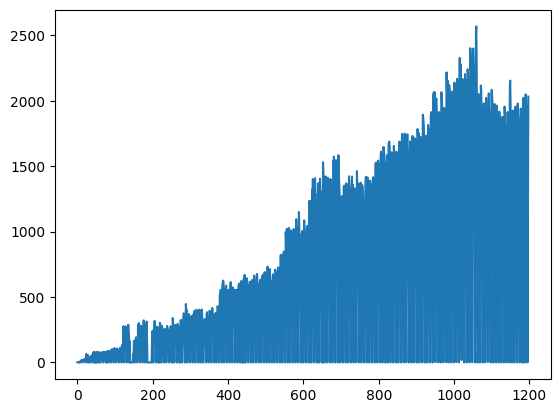

In [62]:
df_teste['loaded_vehicles'].plot()

### Usando a Exponencial

In [63]:
# Fit on loaded_vehicles to forecast daily loads
model = ExponentialSmoothing(df_teste['loaded_vehicles'], trend="add", seasonal=None)
fit = model.fit()

# Forecast the next N days (you can extend if needed)
forecast_days = 365  # try one year first
forecast = fit.forecast(forecast_days)

/home/diogo/Documents/projetos-teste/loaded-vehicles-prediction/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [64]:
last_date = df_teste['delivery_date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_days)
forecast_df = pd.DataFrame({'delivery_date': forecast_dates, 'loaded_vehicles': forecast})

In [65]:
full_df = pd.concat([df_teste[['delivery_date', 'loaded_vehicles']], forecast_df], ignore_index=True)
full_df['cumulative_loaded'] = full_df['loaded_vehicles'].cumsum()


In [68]:
target = 1_200_000
reached = full_df[full_df['cumulative_loaded'] >= target]

if not reached.empty:
    predicted_date = reached.iloc[0]['delivery_date']
    print(f"The company is expected to reach 1 million loaded vehicles on: {predicted_date.date()}")
else:
    print("1 million vehicles not reached in the forecast window. Try extending forecast_days.")


The company is expected to reach 1 million loaded vehicles on: 2024-12-20


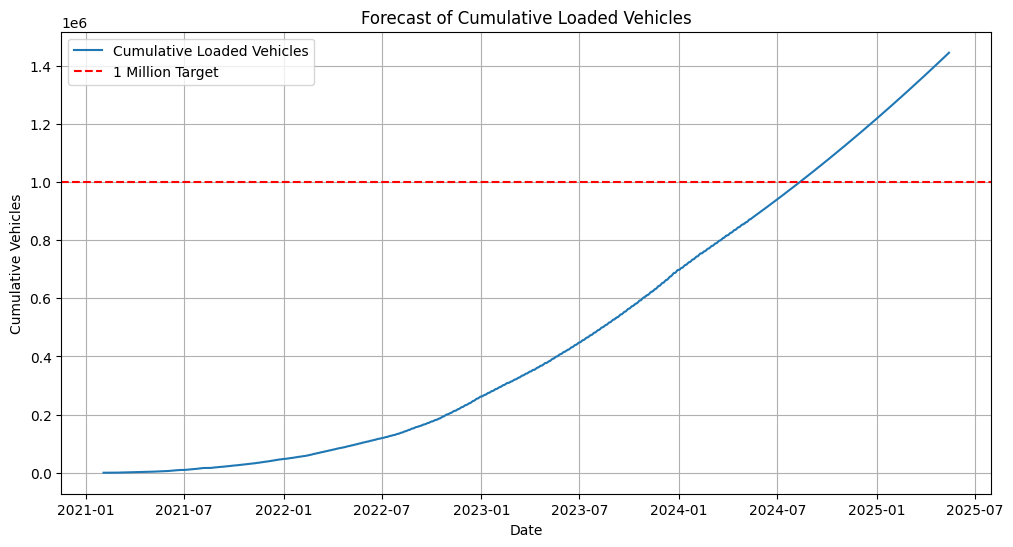

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(full_df['delivery_date'], full_df['cumulative_loaded'], label='Cumulative Loaded Vehicles')
plt.axhline(1_000_000, color='red', linestyle='--', label='1 Million Target')
plt.xlabel('Date')
plt.ylabel('Cumulative Vehicles')
plt.legend()
plt.title('Forecast of Cumulative Loaded Vehicles')
plt.grid(True)
plt.show()

### Usando o Prophet

In [75]:
df_prophet = df_teste[['delivery_date','loaded_vehicles']]
df_prophet = df_prophet.rename(columns={"delivery_date": "ds", "loaded_vehicles": "y"})

df_prophet = df_prophet.sort_values("ds")

df_prophet.head()

,ds,y
0,2021-02-02,1.0
1,2021-02-03,0.0
2,2021-02-04,2.0
3,2021-02-05,3.0
4,2021-02-06,1.0


In [77]:
model = Prophet()
model.fit(df_prophet)

12:19:34 - cmdstanpy - INFO - Chain [1] start processing
12:19:34 - cmdstanpy - INFO - Chain [1] done processing


In [78]:
# Number of future days to forecast
forecast_days = 365

# Create future dataframe
future = model.make_future_dataframe(periods=forecast_days)
forecast = model.predict(future)


In [79]:
# Use forecast['yhat'] for predicted values
combined = df_prophet[['ds', 'y']].copy()
forecast_part = forecast[['ds', 'yhat']][forecast['ds'] > df_prophet['ds'].max()]
forecast_part = forecast_part.rename(columns={'yhat': 'y'})
combined = pd.concat([combined, forecast_part], ignore_index=True)


In [80]:
combined['cumulative_loaded'] = combined['y'].cumsum()


In [82]:
target = 1_200_000
reached = combined[combined['cumulative_loaded'] >= target]

if not reached.empty:
    predicted_date = reached.iloc[0]['ds']
    print(f"The company is expected to reach 1 million loaded vehicles on: {predicted_date.date()}")
else:
    print("1 million vehicles not reached in the forecast window. Try increasing forecast_days.")


The company is expected to reach 1 million loaded vehicles on: 2024-12-10


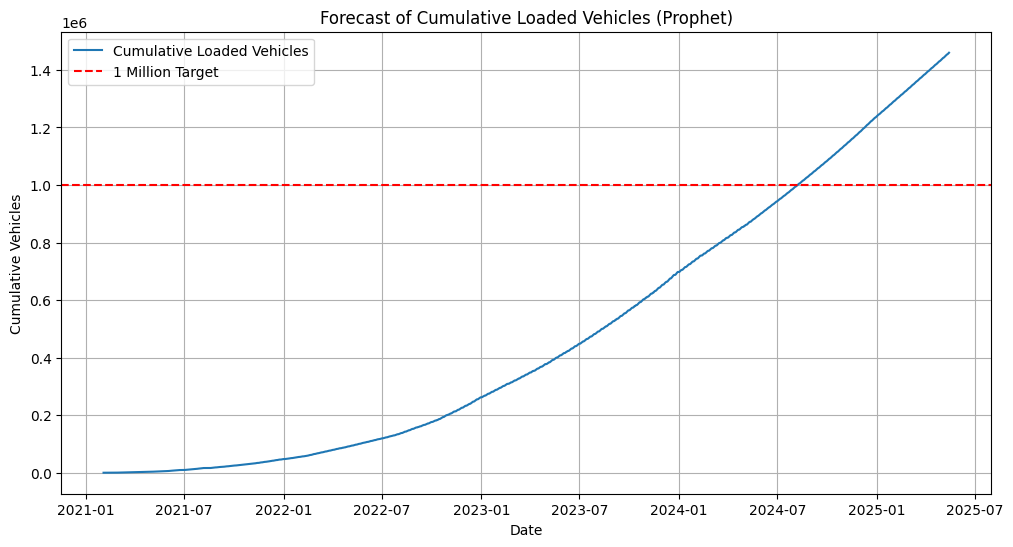

In [83]:
plt.figure(figsize=(12, 6))
plt.plot(combined['ds'], combined['cumulative_loaded'], label='Cumulative Loaded Vehicles')
plt.axhline(1_000_000, color='red', linestyle='--', label='1 Million Target')
plt.xlabel('Date')
plt.ylabel('Cumulative Vehicles')
plt.title('Forecast of Cumulative Loaded Vehicles (Prophet)')
plt.legend()
plt.grid(True)
plt.show()


## Predição Cargas Paletizadas